# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Friends Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Friends script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **30 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [127]:
!pip install nltk
!pip install pyspellchecker
!pip install textblob

In [128]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk
from nltk import pos_tag

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.decomposition import SparsePCA


%matplotlib inline
pd.options.display.max_colwidth=500

In [129]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


In [130]:
'''
#Gender classifier implementation - best results we are getting ~60% which is only slightly better than random guessing so not using 
#this implementation. Could potentially result in poorer ranks since only 60% chance of getting the gender predicted correctly
#This is not used anywhere in the code but left as a reference that gender classifier was tried but was not used
'''

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

samples = train_data.iloc[:1000].dropna()
# Sample dataset (you'll need to replace this with your actual data)
lines = samples["Line"]
genders = samples["Gender"]  # Corresponding gender labels

# Splitting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(lines, genders, test_size=0.2, random_state=42)

# Creating a text processing and classification pipeline
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Training the model
model.fit(X_train, y_train)

# Evaluating the model
predicted = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predicted))


Accuracy: 0.5810055865921788


In [131]:
'''
Create one document per character
generates the context for each character as well
two output - character lines & character context
character_docs- list[(name1, doc1), (name2, doc2)...]
character_context_docs- list[(name1, context_lines1), (name2, context_lines2)...]

Context is chosen based on param context_window
'''

def create_character_document_from_dataframe(df, max_line_count, context_window=1):
    """
    Creates separate documents for each character's lines and their context.
    
    :param df: Dataframe containing the script data.
    :param max_line_count: the maximum number of lines to be added per character.
    :param context_window: the number of lines before and after to use as context.
    :return: A tuple of two dictionaries for lines and context, respectively.
    """
    character_lines = {}
    character_context = {}
    character_line_count = {}
    scene_lines = {}

    for index, row in df.iterrows():
        name = row['Character_name']
        line = row['Line']
        episode = row['Episode']
        scene = row['Scene']

        # Skip empty lines
        if pd.isna(line) or line == "":
            continue

        # Initialize character entries in dictionaries if they don't exist to avoid KeyError
        if name not in character_lines:
            character_lines[name] = []
            character_context[name] = []
            character_line_count[name] = 0

        # Skip if max_line_count for this character has been reached
        if character_line_count[name] >= max_line_count:
            continue

        # Initialize episode and scene entries in scene_lines if they don't exist
        if episode not in scene_lines:
            scene_lines[episode] = {}
        if scene not in scene_lines[episode]:
            scene_lines[episode][scene] = []

        # Update the scene lines
        scene_lines[episode][scene].append((name, line))

        # Get the context for the current line
        current_context = [context_line for context_name, context_line in scene_lines[episode][scene] if context_name != name]

        # Trim the context to keep only the specified window size
        if len(current_context) > 2 * context_window:
            current_context = current_context[-(2 * context_window):]

        # Save the line and its context
        character_lines[name].append(line)
        character_context[name].append(' _EOL_ '.join(current_context))
        character_line_count[name] += 1

    print("Lines per character:", {k: len(v) for k, v in character_lines.items()})
    return character_lines, character_context



In [132]:
train_character_docs, train_context_docs = create_character_document_from_dataframe(train_data, max_line_count=300, context_window = 1)

Lines per character: {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}


In [133]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker

#preprocess function to standardize incoming text and retain only useful parts of character lines.
def pre_process(character_text, tokenize = True, lower = True, remove_punct = True, remove_stopwords = False, spell_checker = False, lemmatize = True):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """

    try :
        # Tokenization
        if tokenize is True :
            tokens = word_tokenize(character_text)
    
        #removing punctuation
        if remove_punct is True :
            tokens = [token for token in tokens if token not in string.punctuation]
        
        #lowercase conversion
        if lower is True :
            tokens = [token.lower() for token in tokens]
        
        # Stopword removal
        if remove_stopwords is True :
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words]
    
        # Spelling correction
        if spell_checker is True :
            spell = SpellChecker()
            tokens = [spell.correction(word) for word in tokens]
    
        # Lemmatization
        if lemmatize is True :
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens if word is not None]
    
        # return tokens
        tokens = [token for token in tokens if token is not None]        #filter out any empty tokens if present
        return ' '.join(tokens)
        
    except Exception as e :
        print(f"Exception occured in preprocessing : {e}")
        print(f"Reverting to basic .split(\s)")
        return character_text.split()

print(pre_process("There's nothing to tell! He's just some guy I work with!"))

there 's nothing to tell he 's just some guy i work with


In [134]:
#Create training corpus of character docs
training_corpus = []
for name, doc in train_character_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    training_corpus.append(character_tuple)

train_labels = [name for name, doc in training_corpus]

#Create the training corpus of context docs
training_context_corpus = []
for name, doc in train_context_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    training_context_corpus.append(character_tuple)


In [135]:
#This cell contains extra feature functions
#First extra feature is POS tagging
#Second function tries extracting sentiment from each line, aggregate scores for each character and use that as a feature

sia = SentimentIntensityAnalyzer()
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

def extract_pos_tags(character_doc):
    """
    Extracts POS tags from a list of tokens.

    ::character_doc:: a list of lists of lines
    :return: a list of POS tags corresponding to the tokens
    """
    if character_doc is None or not character_doc:
        return []

    # POS Tagging
    pos_tags = []
    for line in character_doc :
        tagged = pos_tag(line[0].split())
        tagged = [tag if tag is not None else '' for word,tag in tagged]
        pos_tags.append(' '.join(tagged))
    
    return ' '.join(pos_tags) 


def get_sentiment_scores(line, vader = False):
    """Returns sentiment polarity and subjectivity of the given line of speech."""
    analysis = TextBlob(line)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

def aggregate_character_sentiments(character_docs):
    """
    Aggregates sentiment scores for each character.
    simple mean of polarity and subjectivity values per character
    """
    character_sentiments = []
    polarity_scores = []
    subjectivity_scores = []
    for line in character_docs:
        polarity, subjectivity = get_sentiment_scores(line[0])
        polarity_scores.append(polarity)
        subjectivity_scores.append(subjectivity)

    character_sentiments = [np.mean(polarity_scores), np.mean(subjectivity_scores)]
    return [np.mean(character_sentiments)]


[0.1557094051781552]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [136]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    if character_doc is None:
        # Handle the case where the entire document is None
        processed_text = ''
    else:
        # Filter out None values and ensure all elements are strings
        processed_tokens = [str(token) for token in character_doc if token is not None]
    
    processed_text = ' '.join(processed_tokens)  # Example of joining tokens
    # You can add extra features into the text as well if needed
    return processed_text


In [149]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

tfidfVectorizer  = TfidfVectorizer()     #Vectorizer for tokens in character docs
posVectorizer = TfidfVectorizer()        #Vectorizer for POS tags
contextVectorizer = TfidfVectorizer()    #Vectorizer for context docs

def create_document_matrix_from_corpus(corpus, fitting=False, weights = [1,1,1,1], **kwargs):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q2.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)

    weights : A set of weights to use for each feature/ feature weighting
    This defines how important a feature should be and is tunable to obtain a class of models.

    kwargs : keyword args to get param values for POS, sentiment and context features
    pos : bool -> defines whether to apply and use POS tags as a feature
    sentiment : bool -> defines whether to apply and use sentiment analysis as a feature
    context : bool -> defines whether to use the context data as a feature 
    context_corpus : list -> corpus of context lines for each character to be used as a feature
    """

    #get the weight matrix to weigh the features
    tfidf_weight = weights[0]
    pos_weight = weights[1]
    sentiment_weight = weights[2]
    context_weight = weights[3]
    
    # Fit the TfidfVectorizer if fitting is True and then transform the documents
    final_features = []
    for name, doc in corpus :
            # POS_tags = extract_pos_tags(doc)
            final_features.append(to_feature_vector_dictionary(doc, []))
        
    if fitting:
        tfidfVectorizer.fit(final_features)
    doc_feature_matrix = tfidfVectorizer.transform(final_features)
    weighted_doc_feature_matrix = doc_feature_matrix.multiply(tfidf_weight)
    combined_features = weighted_doc_feature_matrix

    #Vectorize the POS tags using TF-IDF and use them as extra features
    try :
        if kwargs['pos'] == True:
            pos_tags = []
            for name, doc in corpus :
                tags = extract_pos_tags(doc)
                pos_tags.append(tags)
                
            if fitting:
                posVectorizer.fit(pos_tags)
            pos_feature_matrix = posVectorizer.transform(pos_tags)
            
            # Convert the dense POS tag matrix to a sparse matrix
            sparse_pos_tags = csr_matrix(pos_feature_matrix)
            weighted_pos_matrix = sparse_pos_tags.multiply(pos_weight)
            # Concatenate the two feature sets
            combined_features = hstack([weighted_doc_feature_matrix, weighted_pos_matrix])
            
    except Exception as e :
        print(f"Error in pos tag generation given by : {e}")

    #Apply sentiment analysis as a feature only if args are set
    try :
        if kwargs['sentiment'] == True :
            #Produce the sentiment analysis features
            character_sentiment = []
            for name, doc in corpus :
                sentiment = aggregate_character_sentiments(doc)
                character_sentiment.append(sentiment)
        
            character_sentiment = np.array(character_sentiment)
            sentiment_matrix = csr_matrix(character_sentiment)
            weighted_sentiment_matrix = sentiment_matrix.multiply(sentiment_weight)
            
            combined_features = hstack([weighted_doc_feature_matrix, weighted_pos_matrix, weighted_sentiment_matrix])
        
    except Exception as e :
        print(f"Error in Sentiment analysis given by : {e}")
        

    #Check if context bool is set, if set then include context in feature transformations. Apply TF-IDF on the context corpus and use as a feature
    try :
        if kwargs['context'] == True :
            context_corpus = kwargs['context_corpus']
            final_context_features = []
            for name, doc in context_corpus :
                    final_context_features.append(to_feature_vector_dictionary(doc, []))
                
            if fitting:
                contextVectorizer.fit(final_context_features)
            context_feature_matrix = contextVectorizer.transform(final_context_features)
            weighted_context_feature_matrix = context_feature_matrix.multiply(context_weight)
            
            combined_features = hstack([weighted_doc_feature_matrix, weighted_pos_matrix, weighted_sentiment_matrix, weighted_context_feature_matrix])
            
    except Exception as e :
        print(f"Error in Context analysis given by : {e}")

    return combined_features

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, weights = [1.0, 0.25, 0.5, 0.5], pos = True, sentiment=True, context = True, context_corpus = training_context_corpus)


In [150]:
training_feature_matrix
# print(training_feature_matrix.shape)

<10x5088 sparse matrix of type '<class 'numpy.float64'>'
	with 13939 stored elements in Compressed Sparse Row format>

In [151]:
val_character_docs, val_context_docs = create_character_document_from_dataframe(val_data, max_line_count=30, context_window = 1)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")

# create list of pairs of (character name, pre-processed character) 
val_corpus = []
for name, doc in val_character_docs.items() :
    # if(name == '#ALL#') :
    #     continue
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    val_corpus.append(character_tuple)

val_labels = [name for name, doc in val_corpus]


#Create the validation corpus of context docs
val_context_corpus = []
for name, doc in val_context_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    val_context_corpus.append(character_tuple)

Lines per character: {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
Num. Characters:  10 



In [154]:
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False, weights = [1.0, 0.25, 0.5, 0.5], pos = True, sentiment=True, context = True, context_corpus = val_context_corpus)

In [155]:
val_feature_matrix

<10x5088 sparse matrix of type '<class 'numpy.float64'>'
	with 2493 stored elements in Compressed Sparse Row format>

In [156]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [157]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [158]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [159]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.1
mean cosine similarity 0.6940067289901949
4 correct out of 10 / accuracy: 0.4


/tmp/ipykernel_338/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_338/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_338/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_338/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_338/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_338/932186355.py:10: UserWarni

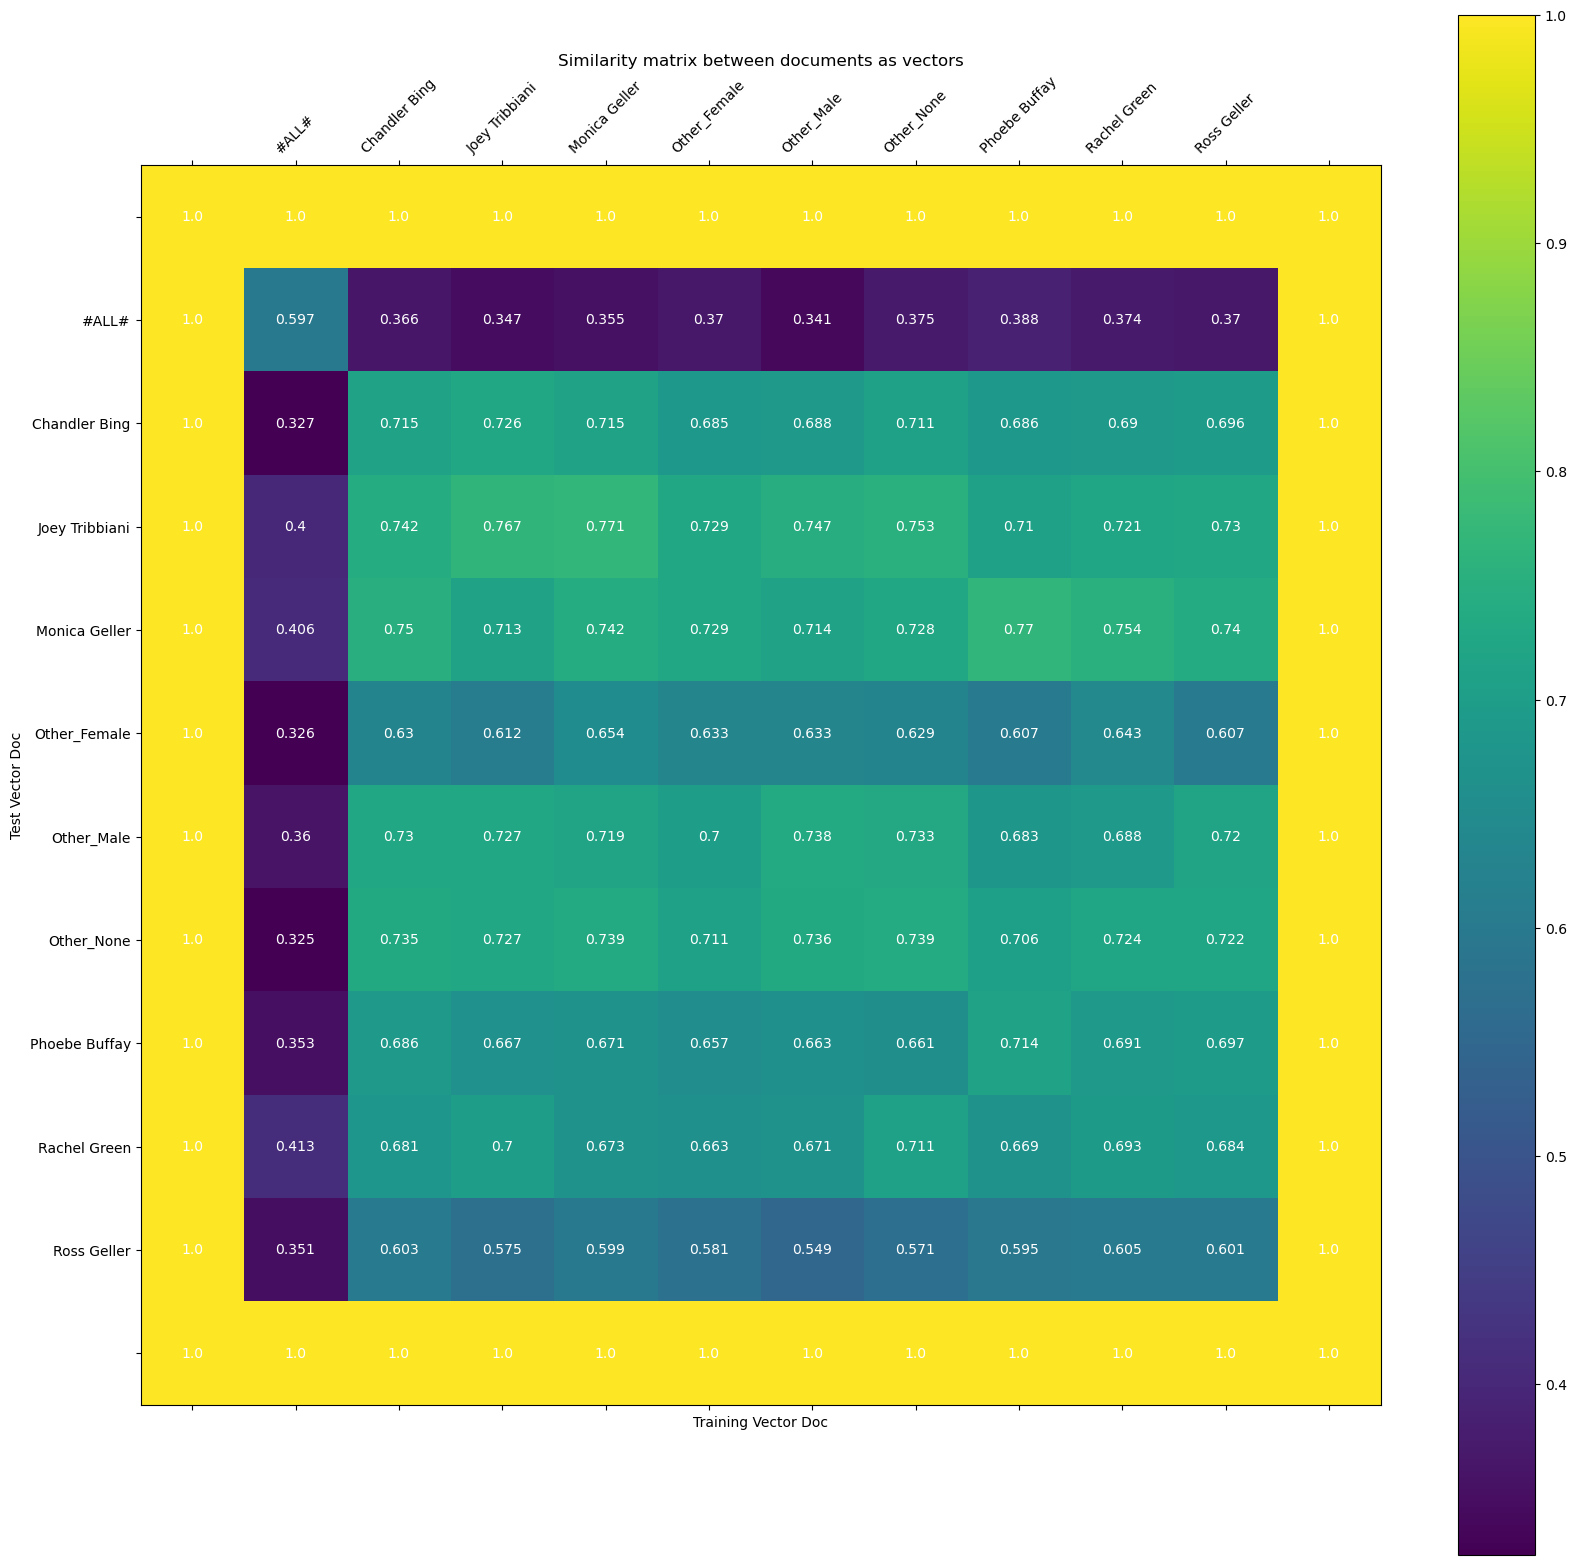

In [160]:
plot_heat_map_similarity(df)

## Grid Search

In [124]:
'''
Grid Search Q1 - Preprocessing techniques
Grid search being performed with only TF-IDF as a feature without using other features
We obtain the optimal set of preprocessing techniques to use
Taking tokenization, lowercase and punctuation removal as mandatory techniques.

Grid search performed over combinations of whether to use stop_word removal, spell checker and lemmatizer
'''
from itertools import product
from sklearn.model_selection import cross_val_score

use_remove_stopwords = [True, False]
use_correct_spelling = [True, False]
use_lemmatize = [True, False]
preprocess_combinations = list(product(use_remove_stopwords, use_correct_spelling, use_lemmatize))

best_mean_rank = 10
best_preprocess_combination = None
best_accuracy = 0

for preprocess_combination in preprocess_combinations :
    remove_stopwords = preprocess_combination[0]
    spell_checker = preprocess_combination[1]
    lemmatize = preprocess_combination[2]
    print(preprocess_combination)
    
    training_corpus = []
    for name, doc in train_character_docs.items() :
        character_tuple = (name, [])
        for line in doc :
            processed_line = pre_process(line, remove_stopwords = remove_stopwords, spell_checker = spell_checker, lemmatize = lemmatize)
            character_tuple[1].append([processed_line])
        training_corpus.append(character_tuple)
    
    train_labels = [name for name, doc in training_corpus]

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = []
    for name, doc in val_character_docs.items() :
        character_tuple = (name, [])
        for line in doc :
            processed_line = pre_process(line, remove_stopwords = remove_stopwords, spell_checker = spell_checker, lemmatize = lemmatize)
            character_tuple[1].append([processed_line])
        val_corpus.append(character_tuple)
    
    val_labels = [name for name, doc in val_corpus]
    

    tfidfVectorizer  = TfidfVectorizer()
    train_combined_features = create_document_matrix_from_corpus(training_corpus, fitting=True, weights = [1,1,1,1], pos = False, sentiment=False, context = False, context_corpus = [])
    val_combined_features = create_document_matrix_from_corpus(val_corpus, fitting=False, weights = [1,1,1,1], pos = False, sentiment=False, context = False, context_corpus = []) 
    
    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(train_combined_features, val_combined_features, train_labels, val_labels)

    #check if current rank is better than the best rank obtained so far, if true, update values
    if mean_rank <= best_mean_rank :
        if acc >= best_accuracy :
            best_mean_rank = mean_rank
            best_accuracy = acc
            best_preprocess_combination = preprocess_combination

print(f"Optimal weight vector : {best_preprocess_combination}")
print(f"Optimal Mean Rank : {best_mean_rank}")
print(f"Optimal Accuracy : {best_accuracy}")

#Optimal weight vector : (True, False, True)
# Optimal Mean Rank : 2.4
# Optimal Accuracy : 0.6

'''
The optimal vector we obtain is remove_stopwords = true, spell_check = false & lemmatize = true/ false
Note : Both values for lemmatizer give same output with basic TF-IDF implemenation), but using lemmatizer improves accuracy when combined with other features so we will toggle it on
Thus optimal combination is given by -
tokenize - true
lowercase - true
remove_punct - true
remove_stopwords = true
spell_check = false
lemmatizer = true
'''

(True, True, True)
mean rank 3.5
mean cosine similarity 0.5066873304891011
5 correct out of 10 / accuracy: 0.5
(True, True, False)
mean rank 3.6
mean cosine similarity 0.5044533325047955
4 correct out of 10 / accuracy: 0.4
(True, False, True)
mean rank 2.4
mean cosine similarity 0.41939643430963763
6 correct out of 10 / accuracy: 0.6
(True, False, False)
mean rank 2.4
mean cosine similarity 0.4198048747684956
6 correct out of 10 / accuracy: 0.6
(False, True, True)
mean rank 3.2
mean cosine similarity 0.7123374697764564
3 correct out of 10 / accuracy: 0.3
(False, True, False)
mean rank 3.4
mean cosine similarity 0.7102275653012089
3 correct out of 10 / accuracy: 0.3
(False, False, True)
mean rank 2.8
mean cosine similarity 0.6885253080325202
2 correct out of 10 / accuracy: 0.2
(False, False, False)
mean rank 2.9
mean cosine similarity 0.6879610176855288
2 correct out of 10 / accuracy: 0.2
Optimal weight vector : (True, False, False)
Optimal Mean Rank : 2.4
Optimal Accuracy : 0.6


In [147]:
'''
Grid Search for Q2 & Q3
Grid search being performed for the feature weights.
Fixing the weight for TF-IDF of character lines to 1 since we want to have that as our main feature
Taking a grid different values for other features weights, parsing it to the model and obtaining the performance metrics and selecting the best one.
'''

tfidf_weights = [1.0]
pos_weights = [0.25, 0.5, 0.75, 1.0]
sentiment_weights = [0.25, 0.5, 0.75, 1.0]
context_weights = [0.25, 0.5, 0.75, 1.0]

# Create a grid of weight combinations
weight_combinations = list(product(tfidf_weights, pos_weights, sentiment_weights, context_weights))
best_mean_rank = 10
best_weights = None
best_accuracy = 0

# Iterate through weight combinations and perform cross-validation
for weights in weight_combinations:
    weights = list(weights)
    print(f"current weights = {weights}")
    tfidfVectorizer  = TfidfVectorizer()     #Vectorizer for tokens in character docs
    posVectorizer = TfidfVectorizer()        #Vectorizer for POS tags
    contextVectorizer = TfidfVectorizer()    #Vectorizer for context doc
    train_combined_features = create_document_matrix_from_corpus(training_corpus, fitting=True, weights = weights, pos = True, sentiment=True, context = True, context_corpus = training_context_corpus)
    val_combined_features = create_document_matrix_from_corpus(val_corpus, fitting=False, weights = weights, pos = True, sentiment=True, context = True, context_corpus = val_context_corpus) 

    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(train_combined_features, val_combined_features, train_labels, val_labels)

    if mean_rank <= best_mean_rank :
        # best_weights = weights
        if acc >= best_accuracy :
            best_mean_rank = mean_rank
            best_accuracy = acc
            best_weights = weights

print(f"Optimal weight vector : {best_weights}")
print(f"Optimal Mean Rank : {best_mean_rank}")
print(f"Optimal Accuracy : {best_accuracy}")


current weights = [1.0, 0.25, 0.25, 0.25]
mean rank 2.6
mean cosine similarity 0.7019149933179996
3 correct out of 10 / accuracy: 0.3
current weights = [1.0, 0.25, 0.25, 0.5]
mean rank 2.2
mean cosine similarity 0.6929361393533439
4 correct out of 10 / accuracy: 0.4
current weights = [1.0, 0.25, 0.25, 0.75]
mean rank 2.5
mean cosine similarity 0.6825724473573689
4 correct out of 10 / accuracy: 0.4
current weights = [1.0, 0.25, 0.25, 1.0]
mean rank 2.4
mean cosine similarity 0.6733362012863731
4 correct out of 10 / accuracy: 0.4
current weights = [1.0, 0.25, 0.5, 0.25]
mean rank 2.4
mean cosine similarity 0.7031336619754949
3 correct out of 10 / accuracy: 0.3
current weights = [1.0, 0.25, 0.5, 0.5]
mean rank 2.1
mean cosine similarity 0.6940067289901949
4 correct out of 10 / accuracy: 0.4
current weights = [1.0, 0.25, 0.5, 0.75]
mean rank 2.3
mean cosine similarity 0.6834614462266286
4 correct out of 10 / accuracy: 0.4
current weights = [1.0, 0.25, 0.5, 1.0]
mean rank 2.4
mean cosine si

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 30 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **10**. Initially, the code in this template achieves a mean rank of **4.0**  and accuracy of **0.3** on the test set and a mean rank of **4.2** and accuracy of **0.1** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. 

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more 
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

From the plotted heatmap we observe that our accuracy is 0.4 for validation i.e. 4 characters had their corresponding vectors in the training set be the ranked first in terms of cosine similarity. These are Joey, Other_Male, Other_None and Pheobe.

**All**: This is a fairly simple category since lines spoken by all characters in unison once is generally as a reaction or a generic sentiment. Thus, this is easily discernible from other characters, and the similarity values reflect the same.

**Joey**: Joey in the sitcom has a specific set of phrases very unique to him. E.g., “How you doin’”. Joey also has a lot of short lines which are usually used in agreement like “yeah!” and his lines are generally shorter than the rest, thus making it possible to differentiate accurately.

**Pheobe**: Phoebe, like Joey, again has a few unique lines in the show like “Smelly Cat” and generally has more reactionary lines which are reactions to others’ lines. Many of her sentences start with the word ‘oh’ unlike the rest of the characters.

**Other_Male**: Looking at the similarity values of Other_Male, it is very similar to all of the guy cast with the similarity varying only at the second or third decimal place. This shows that there is little to differentiate lines spoken by other male characters and thus difficult to conclude anything. Potential use of different sets of 300 lines could result in fluctuations for this category.

**Other_None**: Similar to Other_Male, the similarities for this category with others are almost the same, only differing by the second decimal. Thus, implying that there is little insight available to differentiate this category and will be susceptible to fluctuations for different training sets of size = 300.

The following characters had their corresponding counterparts in the training set not ranked first when ordered by similarity. Given we obtained a mean rank of 2.1 for validation, we can generalize that the correct character was ranked in the top 2 on average for the remaining 6 characters.

**Chandler**: Joey was top-ranked with Chandler second. This could be due to the reason that Joey and Chandler have lines together in most scenes and Chandler being a sarcastic character could have lines potentially mocking whatever Joey said, and thus we see Joey being ranked first.

**Monica**: For Monica, Rachel was ranked first and Monica second. Similar to Joey and Chandler, Rachel and Monica have most scenes together and them being best friends also implies similar styles of speaking, resulting in Rachel being ranked higher.

**Other_Female**: This category had Monica as the top rank but had close values with the main female characters. Like the case with Other_None and Other_Male, it is hard to generalize these lines since a different training set could result in different values for similarity due to the changes characters considered as ‘Other’.

**Rachel**: For Rachel, the category ‘Other_None’ was top-ranked with ‘Joey’ being second. This seems like an anomaly for the model since the correct character was ranked third after ‘Other_None’ and ‘Joey’. This could possibly be due to a lack of uniqueness for Rachel’s dialogues in the first few scenes where we get the 300 lines from and hence they are similar to the lines spoken by trivial characters. We could potentially try to sample a different set of 300 lines and see whether the similarities change and we are able to correctly rank ‘Rachel’ in the testing set.

**Ross**: For Ross, the top-ranked result was surprisingly Rachel! However, we can note that Ross and Rachel have the most dialogue with each other than any other pair of characters in the series, hence this could be a potential reason for Ross’s vector being most similar to ‘Rachel’.


# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 30 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [148]:

train_character_docs, train_context_docs = create_character_document_from_dataframe(train_data, max_line_count=300, context_window = 1)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")

training_corpus = []
for name, doc in train_character_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    training_corpus.append(character_tuple)

train_labels = [name for name, doc in training_corpus]

#Create the training corpus of context docs
training_context_corpus = []
for name, doc in train_context_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    training_context_corpus.append(character_tuple)
train_labels = [name for name, doc in training_corpus]


# get the test data using 30 lines per character
test_character_docs, test_context_docs = create_character_document_from_dataframe(test_data, max_line_count=30, context_window = 1)

test_corpus = []
for name, doc in test_character_docs.items() :
    # if(name == '#ALL#') :
    #     continue
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    test_corpus.append(character_tuple)


#Create the validation corpus of context docs
test_context_corpus = []
for name, doc in test_context_docs.items() :
    character_tuple = (name, [])
    for line in doc :
        processed_line = pre_process(line)
        character_tuple[1].append([processed_line])
    test_context_corpus.append(character_tuple)
    
test_labels = [name for name, doc in test_corpus]

#initialize global vectorizers
tfidfVectorizer  = TfidfVectorizer()     #Vectorizer for tokens in character docs
posVectorizer = TfidfVectorizer()                           #Vectorizer for POS tags
contextVectorizer = TfidfVectorizer()    #Vectorizer for context doc

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, weights = [1.0, 0.25, 0.5, 0.5], pos = True, sentiment=True, context = True, context_corpus = training_context_corpus)
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, weights = [1.0, 0.25, 0.5, 0.5], pos = True, sentiment=True, context = True, context_corpus = val_context_corpus) 

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

Lines per character: {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

Lines per character: {'Ross Geller': 30, 'Joey Tribbiani': 30, 'Chandler Bing': 30, 'Other_Female': 30, 'Other_None': 30, '#ALL#': 11, 'Monica Geller': 30, 'Rachel Green': 30, 'Phoebe Buffay': 30, 'Other_Male': 30}
mean rank 2.5
mean cosine similarity 0.6724294222780802
5 correct out of 10 / accuracy: 0.5
